In [1]:
import os
import fastmri
from fastmri.data import transforms
import numpy as np
import torch
import pytorch_lightning as pl
import PIL
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import nibabel as nib
import pydicom

%matplotlib inline

In [2]:
base_folder = "/data/projects/dwi_aisd/dicoms"
file_names = os.listdir(base_folder)
output_dir = "/data/projects/dwi_aisd/DWIs_nii/"

In [3]:
import dicom2nifti

for dicom_id in file_names:
    in_dir = os.path.join(base_folder, dicom_id, "DWI")
    dicom_files = os.listdir(in_dir)
    out_name = os.path.join(output_dir, dicom_id + "_DWI" + ".nii.gz")
    if os.path.isfile(out_name):
        continue
    if not os.path.isfile(os.path.join(in_dir, dicom_files[0])):
        for i in dicom_files:
            in_dir = os.path.join(base_folder, dicom_id, "DWI", i)
            out_name = os.path.join(output_dir, dicom_id + "_" + i + "_DWI" + ".nii.gz")
            if os.path.isfile(out_name):
                continue
            dicom2nifti.dicom_series_to_nifti(in_dir, out_name, reorient_nifti=False)
    else:
        dicom2nifti.dicom_series_to_nifti(in_dir, out_name, reorient_nifti=False)

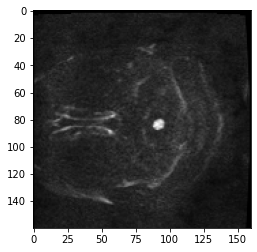

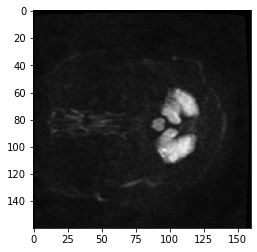

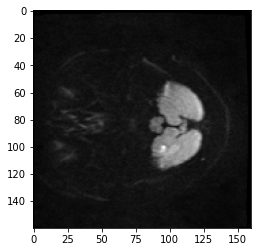

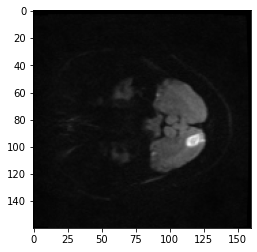

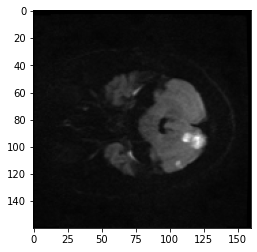

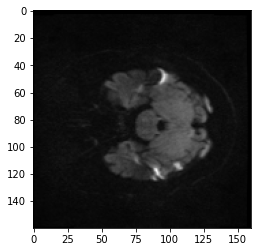

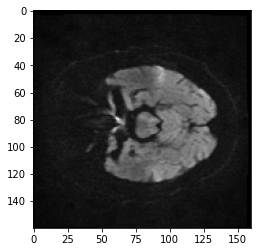

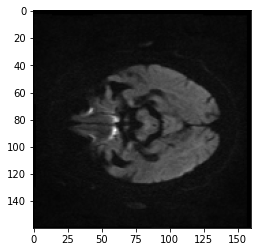

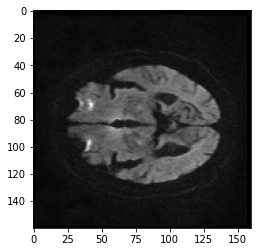

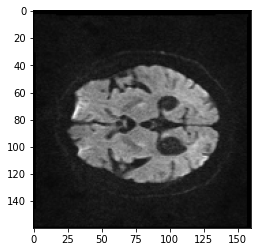

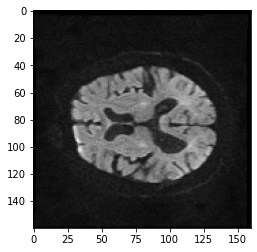

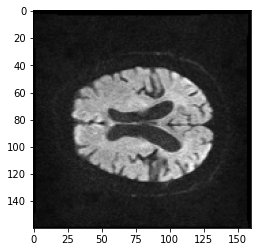

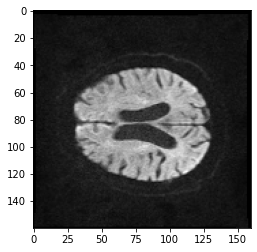

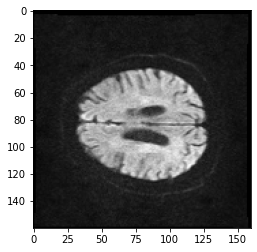

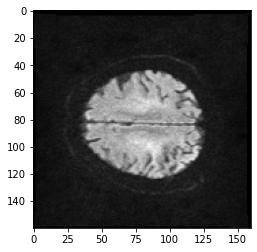

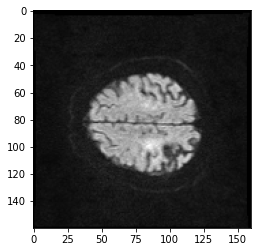

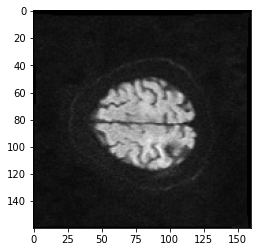

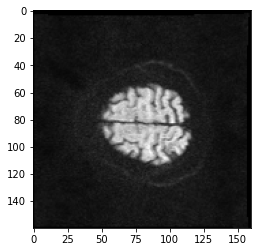

In [4]:
nii_file_path = "/data/projects/dwi_aisd/DWIs_nii/0019983_DWI.nii.gz"
nii = nib.load(nii_file_path)
# nii = nib.as_closest_canonical(nii)
nii_numpy = np.array(nii.dataobj)
transform = np.array(nib.load(nii_file_path).affine)
for i in range(18):
    plt.imshow(nii_numpy[:, :, i], cmap="gray")
    plt.show()

(512, 512, 17)
0.0 0.20665069947759784 1.0


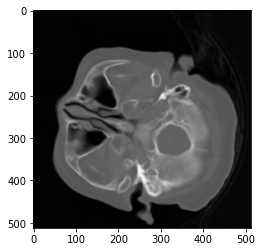

0.0 0.21508874764077796 1.0


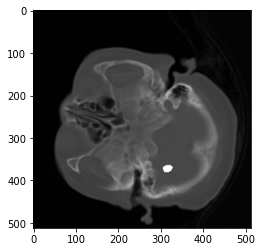

0.0 0.19608420663144321 1.0


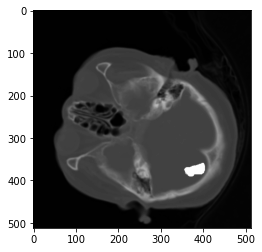

0.0 0.21771877145027108 1.0


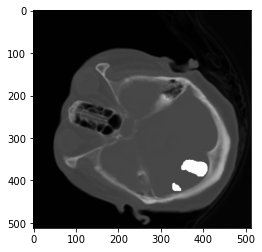

0.0 0.22403114652794215 1.0


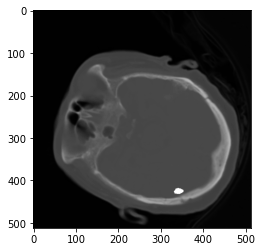

0.0 0.230916638240636 1.0


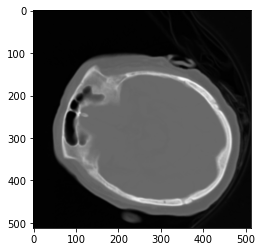

0.0 0.2269276658755366 1.0


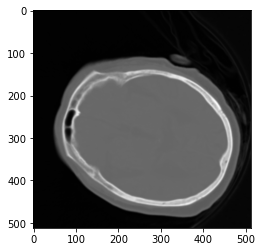

0.0 0.22045692073488693 1.0


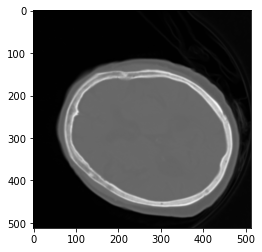

0.0 0.22681945825501848 1.0


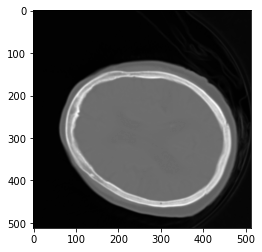

0.0 0.22106238374492634 1.0


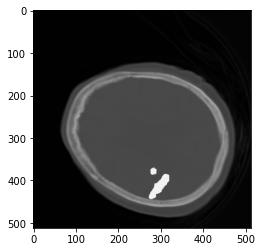

0.0 0.21109203479793215 1.0


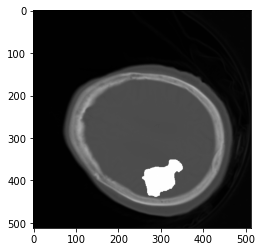

0.0 0.20582491964907257 1.0


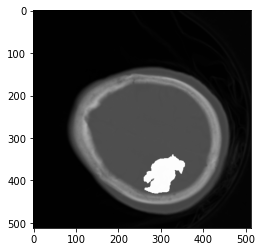

0.0 0.19751425088788363 1.0


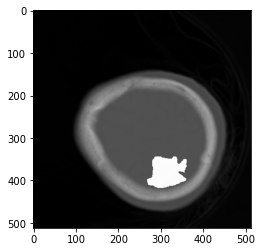

0.0 0.17930175760433098 1.0


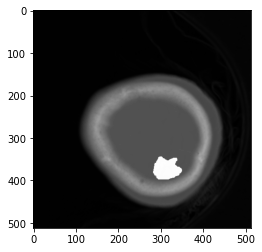

0.0 0.15720365812193673 1.0


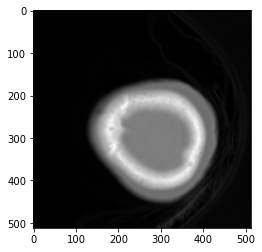

0.0 0.11588837943687569 1.0


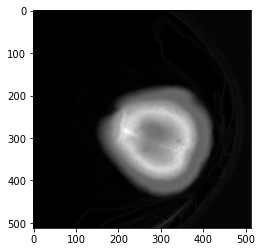

0.0 0.08770266802942166 1.0


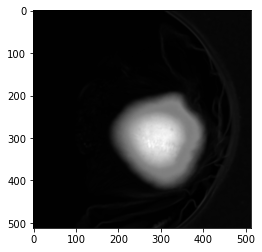

In [5]:
ct_file_path = "/data/projects/dwi_aisd/CTs_laura/0019983_CT.nii.gz"
mask_file_path = "/data/projects/dwi_aisd/Masks_laura/0019983_mask.nii.gz"
ct = nib.load(ct_file_path)
nicti = nib.as_closest_canonical(ct)
ct_numpy = np.array(ct.dataobj)
mask_numpy = np.array(nib.load(mask_file_path).dataobj)
print(ct_numpy.shape)
for i in range(17):
    ct = ct_numpy[:, :, i]
    ct = (ct - ct.mean())/ct.std()
    ct -= np.min(ct)
    ct = np.divide(ct, np.max(ct))
    print(np.min(ct), np.mean(ct), np.max(ct))
    mask = mask_numpy[:, :, i]/(max(1, np.max(mask_numpy[:, :, i])))
    plt.imshow(ct + mask, cmap="gray")
    plt.show()

In [105]:
import itk
from itkwidgets import view, compare, checkerboard

def read_nii(nii_path, retain_rotation=False, low_thresh=None, high_thres=None):
    image = itk.imread(nii_path)
    array = np.array(nib.load(nii_path).dataobj).astype(np.float32)
    if len(array.shape) == 4:
        array = array[:, :, :, -1]

    array[array < 0] = 0
    if low_thresh or high_thres:
        print(f"Array stats: mean:{np.mean(array)}, std:{np.std(array)}, low-thres:{np.mean(array) - (np.std(array)/2)}, high-thres:{np.mean(array) + (np.std(array)/2)}.")

    if low_thresh is not None:
        low_tresh = np.mean(array) - (np.std(array)/2)
        array[array < low_tresh] = 0

    if high_thres is not None:
        high_thres = np.mean(array) + (np.std(array)/2)
        array[array > high_thres] = 0

    array -= np.min(array)
    array = array/np.max(array)

    array = itk.image_from_array(array)
    spacing = itk.spacing(image)
    array.SetSpacing([spacing[0], spacing[1], spacing[2]])

    if retain_rotation:
        direction = image.GetDirection()
        array.SetDirection(direction)

    return array

def register_image_mask(fixed_image_file_path, moving_image_file_path, mask_file_path, return_moving_image=False):
    fixed_image = read_nii(fixed_image_file_path, low_thresh=True, retain_rotation=True)
    fixed_image.SetOrigin([0 for i in range(len(fixed_image.shape))])

    moving_image = read_nii(moving_image_file_path, low_thresh=True, high_thres=True)
    mask = read_nii(mask_file_path)

    moving_image, _ = resample(moving_image, itk.size(fixed_image))
    mask, origin = resample(mask, itk.size(fixed_image), interpolator=itk.NearestNeighborInterpolateImageFunction)
    fixed_image.SetOrigin([0 for i in range(len(fixed_image.shape))])

    parameter_object = itk.ParameterObject.New()
    rigid_parameter_map = parameter_object.GetDefaultParameterMap('translation')
    parameter_object.AddParameterMap(rigid_parameter_map)
    affine_parameter_map = parameter_object.GetDefaultParameterMap('affine')
    parameter_object.AddParameterMap(affine_parameter_map)
    # bspline_parameter_map = parameter_object.GetDefaultParameterMap('bspline')
    # parameter_object.AddParameterMap(bspline_parameter_map)

    elastix_object = itk.ElastixRegistrationMethod.New(fixed_image, moving_image)
    elastix_object.SetFixedImage(fixed_image)
    elastix_object.SetMovingImage(moving_image)
    elastix_object.SetParameterObject(parameter_object)
    elastix_object.SetNumberOfThreads(8)

    elastix_object.SetLogToConsole(True)

    elastix_object.UpdateLargestPossibleRegion()

    transformed_moving_image = elastix_object.GetOutput()
    transform_parameters = elastix_object.GetTransformParameterObject()

    transformed_mask = transform_mask(mask, transform_parameters)

    if return_moving_image:
        return transformed_mask, origin, transformed_moving_image
    return transformed_mask, origin

def resample(image, output_size, remove_origin=True, interpolator=itk.BSplineInterpolateImageFunction):
    input_size = itk.size(image)
    input_spacing = itk.spacing(image)
    input_origin = itk.origin(image)

    output_size = [output_size[0], output_size[1], output_size[2]]
    output_spacing = [input_spacing[0] * (input_size[0]/output_size[0]),
                        input_spacing[1] * (input_size[1]/output_size[1]),
                        input_spacing[2] * (input_size[2]/output_size[2])]
    output_origin = [input_origin[d] + 0.5 * (output_spacing[d] - input_spacing[d]) for d in range(3)]

    interpolator = interpolator.New(image)

    image = itk.resample_image_filter(
        image,
        interpolator=interpolator,
        size=output_size,
        output_spacing=output_spacing,
        output_origin=output_origin
    )

    origin = itk.origin(image)

    if remove_origin:
        image.SetOrigin([0 for i in range(len(image.shape))])

    return image, origin

def transform_mask(mask, transform_object):
    # Load Transformix Object
    transform_object.SetParameter('FinalBSplineInterpolationOrder','0')
    transformix_object = itk.TransformixFilter.New(mask)
    transformix_object.SetTransformParameterObject(transform_object)

    # Update object (required)
    transformix_object.UpdateLargestPossibleRegion()

    # Results of Transformation
    result_image = transformix_object.GetOutput()
    return result_image


In [106]:
fixed_image_file_path = "/data/projects/dwi_aisd/DWIs_nii/0021023_DWI.nii.gz"
moving_image_file_path = "/data/projects/dwi_aisd/CTs_laura/0021023_CT.nii.gz"
mask_file_path = "/data/projects/dwi_aisd/Masks_laura/0021023_mask.nii.gz"

In [107]:
transformed_mask, _, transformed_moving_image = register_image_mask(fixed_image_file_path,
                                                                moving_image_file_path,
                                                                mask_file_path,
                                                                return_moving_image=True)

Array stats: mean:37.736690521240234, std:49.063167572021484, low-thres:13.205106735229492, high-thres:62.26827430725098.
Array stats: mean:94.30606079101562, std:261.48956298828125, low-thres:-36.438720703125, high-thres:225.05084228515625.


In [93]:
compare(read_nii(fixed_image_file_path), read_nii(moving_image_file_path))

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [97]:
compare(read_nii(fixed_image_file_path, retain_rotation=True), transformed_moving_image)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [108]:
DWI_base_folder = '/data/projects/dwi_aisd/DWIs_nii/'
CT_base_folder = '/data/projects/dwi_aisd/CTs_laura/'
mask_base_folder = '/data/projects/dwi_aisd/Masks_laura/'

mask_output_folder= '/data/projects/dwi_aisd/masks_DWI/'

dicom_ids = os.listdir(DWI_base_folder)
dicom_ids = [i[:-11] for i in dicom_ids]

for dicom_id in dicom_ids:
    dwi_path = os.path.join(DWI_base_folder, dicom_id + "_DWI.nii.gz")
    ct_path = os.path.join(CT_base_folder, dicom_id.split('_')[0] + "_CT.nii.gz")
    mask_path = os.path.join(mask_base_folder, dicom_id.split('_')[0] + "_mask.nii.gz")
    output_path = os.path.join(mask_output_folder, dicom_id + "_mask.nii.gz")

    # if os.path.isfile(output_path):
    #     continue

    try:
        transformed_mask, origin = register_image_mask(dwi_path,
                                                ct_path,
                                                mask_path)
        transformed_mask.SetOrigin(origin)
        itk.imwrite(transformed_mask.astype(itk.UC), output_path)
    except Exception as e:
        print(f'{dicom_id} not processed.')

Array stats: mean:30.411094665527344, std:35.188045501708984, low-thres:12.817071914672852, high-thres:48.005117416381836.
Array stats: mean:64.9833755493164, std:196.8051300048828, low-thres:-33.419189453125, high-thres:163.3859405517578.
Array stats: mean:37.736690521240234, std:49.063167572021484, low-thres:13.205106735229492, high-thres:62.26827430725098.
Array stats: mean:94.30606079101562, std:261.48956298828125, low-thres:-36.438720703125, high-thres:225.05084228515625.
Array stats: mean:40.714725494384766, std:81.59492492675781, low-thres:-0.08273696899414062, high-thres:81.51218795776367.
Array stats: mean:101.39815521240234, std:295.2330627441406, low-thres:-46.21837615966797, high-thres:249.01468658447266.
Array stats: mean:31.45146369934082, std:41.72075653076172, low-thres:10.591085433959961, high-thres:52.31184196472168.
Array stats: mean:41.43933868408203, std:143.7263641357422, low-thres:-30.423843383789062, high-thres:113.30252075195312.
Array stats: mean:32.5391044616

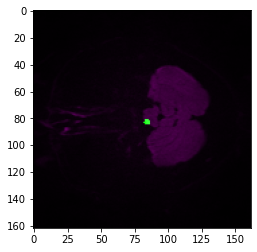

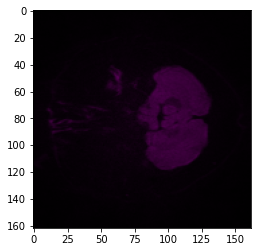

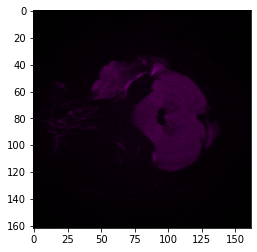

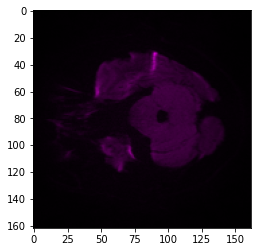

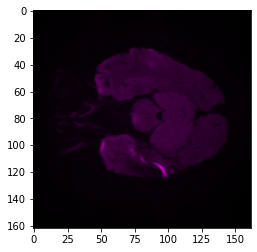

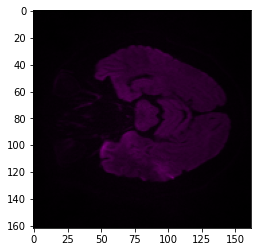

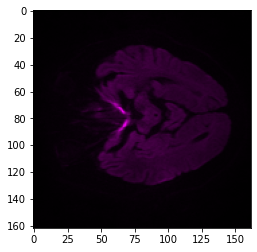

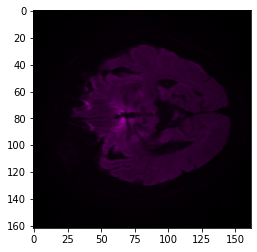

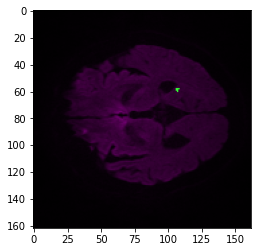

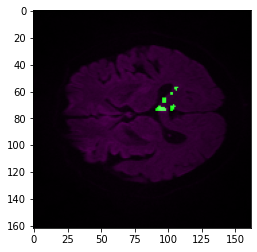

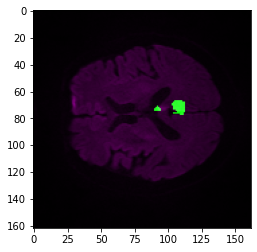

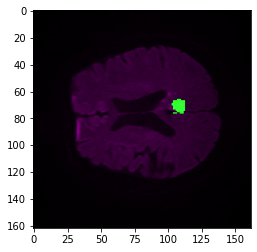

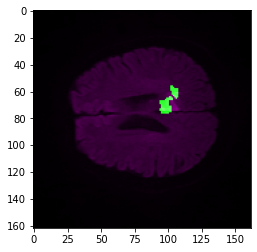

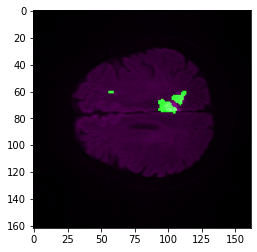

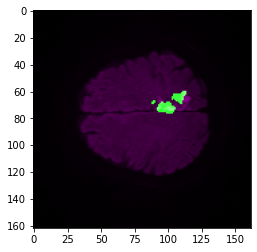

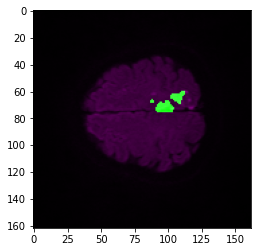

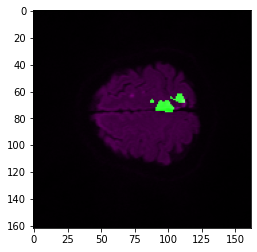

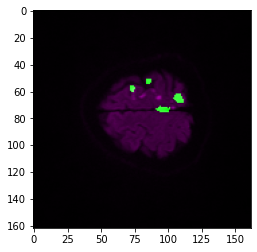

In [100]:
test = np.array(nib.load(fixed_image_file_path).dataobj)
test = test/np.max(test)
trans_mask_array = np.array(nib.load("/data/projects/dwi_aisd/masks_DWI/0021023_mask.nii.gz").dataobj)

for i in range(test.shape[-1]):
    image = test[:, :, i]
    mask = trans_mask_array[:, :, i]

    c_img = np.zeros((image.shape[0], image.shape[1], 3))
    c_img[:, :, 0] = image
    c_img[:, :, 2] = image
    c_img[:, :, 1] = mask

    plt.imshow(c_img)
    plt.show()